# Introduction to GIS in Python

# 1 Introduction

 ##### Before beginning this course, there are some prerequisite steps required.<br>
 > Make sure these are all fulfilled before you continue.
- You should already have an Artifactory account set up. If not, contact the Service Desk and request for one.
- In the data folder, open the **Installation Guide for Geopandas** document and follow the instructions given.
- You should allow for up to 20 minutes to install the packages
- Once all the above requirements have all been met, you are ready to get started!

## 1.1 Set up Python

- Open the Notebook **'Intro to GIS in Python Workbook'**. 
- As you make your way through the guided exercises on this Notebook, you may use the Workbook as your workspace.
- Read through each exercise and try out your solution on the Template Notebook and check your output against the solution on this Notebook.<br>

*Goodluck!*

## 1.2 Quick Python basics
- Python is case sensitive - read_csv is not the same as read_CSV.
- New objects are created using the **`=`** notation, e.g **`new_object = 2 * 5`** .
- To overwrite an object use **`=`** and its current name, e.g. **`current_object = current_object.buffer(1000)`**. 
- To see a function’s documentation in Python, pass the function inside the brackets of the **`help()`** function.
- Write in the code editor (script) and execute your code line by line.
- Use Ctrl + Enter to execute the current line of code.

## 1.3 Install & load Python libraries

In [1]:
#Import all the Python packages required for the course ...
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import mapclassify
from mapclassify import Quantiles, UserDefined
from matplotlib import cm
import numpy as np
from pathlib import Path
%matplotlib inline
BASE = Path('.').resolve() #Set path

## 1.4 Aims

**By the end of today you will:**

- Understand what spatial data and GIS are.
- Know how to use the Open Geography Portal.
- Be aware of map projections and Coordinate Reference Systems (CRS) and be able to modify them.
- Be able to load and manipulate spatial data in Python using the geopandas library.
- Be familiar with using GSS codes to join statistics to geographies.
- Understand how to use spatial joins.
- Know how to make static maps in matplotlib.
- Be able to export your maps and shapefiles.

## 1.5 GIS in Python

With the continued development of **Geopandas**, working with Geospatial data in Python has been made easier. **Geopandas** makes the benefits of **Pandas** available in a geospatial format by combining its capabilities with **Shapely**. **Matplotlib** allows for the basic plotting of geospatial vector data in Python. There is a growing list of GIS related packages for Python that unlock even more spatial capability. For now, we will focus on **Geopandas** and **Matplotlib**.

# 2 Working with spatial data in Python

## 2.1 Exercise - Open Geography Portal
- Go to the Open Geography Portal and download the 2019 Local Authority District BGC boundaries. Save them to data/shp in your project structure and unzip.
- Open the folder and see how many different files there are. <br>
> A shapefile is a vector data storage format for storing the location, shape, and attributes of geographic features. It is stored as a set of related files (**`.shp`**, **`.shx`**, **`.dbf`**, and **`.prj`**) and contains one feature class. All components of a shapefile must always be kept together. It is generally good practice to save a shapefile in its own folder.

## 2.2 London Fire Brigade Animal Rescue Data
Throughout this tutorial we will be using data from the London Fire Brigade - LFB Animal Rescue Data. It covers all incidents between 2009 and 2020 which included assistance to animals that may be trapped or in distress. The data is updated monthly and includes a range of variables for each incident including some location information (postcode, borough, ward),the date/time of the incidents, cost, and type of animal in trouble.

We want to visualise, and better understand how much money has been spent on animal related incidents between 2009 and 2020, and what the distribution is at the MSOA level of geography. To achieve this we will have to import spatial data, manipulate it and create summary statistics, and then plot it

## 2.3 Loading spatial and non-spatial data
LFB data has been tidied up and saved as a Comma Separated Value file (.csv). We can use **`read_csv()`** to open it in Python.

### 2.3.1 Exercise - open LFB data
- Create a new object called **`lfb`** by using **`read_csv()`**. Load data located in **“data/csv/lfb_2009_2020.csv”.**
- Use **`.head()`** to view **`lfb`** structure.

**Solution**

In [2]:
lfb = pd.read_csv('data/csv/lfb_2009_2020.csv')
lfb.head()

,incident_number,cal_year,type_of_incident,cost_gbp,final_description,animal_group_parent,property_category,ward_code,ward,stn_ground_name,easting,northing
0,D1,2009,Special Service,510.0,"DOG WITH JAW TRAPPED IN MAGAZINE RACK,B15",Dog,Dwelling,E05011467,Crystal Palace & Upper Norwood,Norbury,532350,170050
1,F2,2009,Special Service,255.0,"ASSIST RSPCA WITH FOX TRAPPED,B15",Fox,Outdoor Structure,E05000169,Woodside,Woodside,534750,167550
2,D3,2009,Special Service,255.0,"DOG CAUGHT IN DRAIN,B15",Dog,Outdoor Structure,E05000558,Carshalton Central,Wallington,528050,164950
3,H4,2009,Special Service,255.0,"HORSE TRAPPED IN LAKE,J17",Horse,Non Residential,E05000330,Harefield,Ruislip,504650,190650
4,R5,2009,Special Service,255.0,"RABBIT TRAPPED UNDER SOFA,B15",Rabbit,Dwelling,E05000310,Gooshays,Harold Hill,554650,192350


lfb is currently just a data frame. It has not got an explicit geometry column which links observations to their geographic location. It does however contain several columns which can be used to convert it into a spatial data format.

Ward_code column references the GSS codes of wards within which the observations fall. GSS codes can be used to join lfb data to boundaries from the Open Geography Portal. One issue with this particular column is that it does not indicate the currency of GSS codes. Wards are subject to frequent change, and as such it is best practice to be clear about the dates of any boundaries used by stating the exact code used, e.g. wd19cd. Because LFB data does not include this information we have no guarantee that the boundaries and GSS codes we join will match.

Fortunately we have also been provided with columns recording the easting, and northing of each incident. We can use those to convert **`lfb`** into a GeoDataFrame. A GeoDataFrame is a spatially enabled pandas DataFrame meaning that everything you know about how to work with a pandas DataFrame can be used for this as well. To achieve this we will use the **`gpd.GeoDataFrame()`** function which takes the following arguments:<br>
>**`new_object = gpd.GeoDataFrame(input_data_frame, geometry = gpd.points_from_xy(input_data_frame.x_coordinate_column, input_data_frame.y_coordinate_column), crs = 27700)`**

In [3]:
lfb_gdf  = gpd.GeoDataFrame(lfb,
                              geometry=gpd.points_from_xy(lfb.easting, 
                                                          lfb.northing), crs = 'EPSG:27700')

In [4]:
lfb_gdf.head()

,incident_number,cal_year,type_of_incident,cost_gbp,final_description,animal_group_parent,property_category,ward_code,ward,stn_ground_name,easting,northing,geometry
0,D1,2009,Special Service,510.0,"DOG WITH JAW TRAPPED IN MAGAZINE RACK,B15",Dog,Dwelling,E05011467,Crystal Palace & Upper Norwood,Norbury,532350,170050,POINT (532350.000 170050.000)
1,F2,2009,Special Service,255.0,"ASSIST RSPCA WITH FOX TRAPPED,B15",Fox,Outdoor Structure,E05000169,Woodside,Woodside,534750,167550,POINT (534750.000 167550.000)
2,D3,2009,Special Service,255.0,"DOG CAUGHT IN DRAIN,B15",Dog,Outdoor Structure,E05000558,Carshalton Central,Wallington,528050,164950,POINT (528050.000 164950.000)
3,H4,2009,Special Service,255.0,"HORSE TRAPPED IN LAKE,J17",Horse,Non Residential,E05000330,Harefield,Ruislip,504650,190650,POINT (504650.000 190650.000)
4,R5,2009,Special Service,255.0,"RABBIT TRAPPED UNDER SOFA,B15",Rabbit,Dwelling,E05000310,Gooshays,Harold Hill,554650,192350,POINT (554650.000 192350.000)


**`gpd.GeoDataFrame()`** converted the easting and northing columns to simple feature geometries and created a new column called geometry which holds spatial information for each row. Now that **lfb** is a spatial object we can plot it using the matplotlib package. For now we will use the **`.plot()`** function which creates a map, then run the **`plt.show()`** function to visualise the map.

### 2.3.2 Exercise - quick static maps
- Plot **`lfb_gdf`** using the **`.plot()`** function.

*Solution*

<AxesSubplot:>

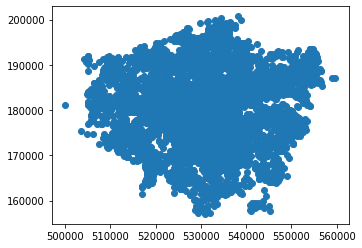

In [5]:
lfb_gdf.plot()

## 2.4 Filtering by GSS code
It looks like some of the locations are located outside of London, however we are only interested in incidents within the Local Authority Districts making up Greater London. To remove all points outside of London we will have to first import the LAD boundaries which we downloaded from the Open Geography Portal and then use them to spatially filter **`lfb_gdf`** data.

So far we have created our own sf objects by adding a geometry column. The LAD data set is already a spatial one and as such we can use the **`gpd.read_file()`** function from the Geopandas package to import it. **`gpd.read_file()`** is extremely versatile and able to import most spatial data formats into Python. The only argument that needs to be supplied to **`gpd.read_file()`** is the full path to the LAD boundaries

### 2.4.1 Exercise - loading shapefiles
- Use **`gpd.read_file()`** to load the UTLA boundaries as **`utla_2019`**.

- Make a static map of the object you have just created using **`.plot()`**.<br>
>*Solution*

In [6]:
utla_2019 = gpd.read_file('data/shp/London_2019/London_and_surrounding_UTLAs.shp')

<AxesSubplot:>

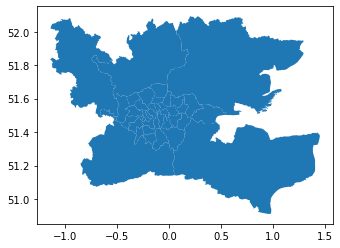

In [7]:
utla_2019.plot()

UTLA boundaries have loaded correctly but they currently cover the outskirts of London when all we need is Greater London. Because GeoDataFrames are data frames with a geometry column attached, any operations that we would perform on a normal data frame can also be performed on a GeoDataFrame. Here we will use **`.loc`** and **`.str.startswith()`** from pandas to only keep UTLAs whose GSS code starts with “E09”.

### 2.4.2 Exercise - filter spatial data by variable
- Inspect **`utla_2019`** using **`.head()`**, and identify which column holds the GSS codes - it should end in “cd”.
- Create a new object called **`london_utla`**. Use **`.loc`** alongside **`.str.startswith()`** to only keep observations which have a GSS code starting with “E09”.
- Plot **`london_utla`** to see if the results look correct.

*Solution*

In [8]:
utla_2019.head()

,ctyua19cd,ctyua19nm,geometry
0,E06000034,Thurrock,"POLYGON ((0.39195 51.56573, 0.39198 51.56530, ..."
1,E06000039,Slough,"POLYGON ((-0.62395 51.53779, -0.62379 51.53777..."
2,E10000002,Buckinghamshire,"POLYGON ((-0.95011 52.07975, -0.95007 52.07975..."
3,E10000012,Essex,"POLYGON ((0.68347 52.08695, 0.68367 52.08692, ..."
4,E10000015,Hertfordshire,"POLYGON ((-0.15731 52.08035, -0.15727 52.08035..."


<AxesSubplot:>

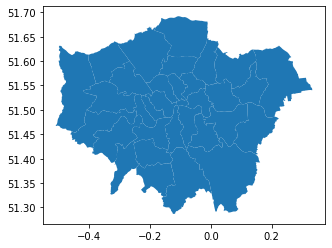

In [9]:
london_utla = utla_2019.loc[utla_2019['ctyua19cd'].str.startswith('E09')]
london_utla.plot()

Finally, for the next step, we only need the outer boundary of London - all the internal UTLA boundaries have to be removed and only the outer edges kept. Geopandas has a function exactly for this purpose called **`.dissolve()`**. It only takes one argument, which is the GeoDataFrame we want to dissolve. But first, we will have to create a new column and assign it a common variable for the dissolve function.

### 2.4.3 Exercise - dissolve boundaries
- Create a new column and assign a common variable for all rows
- Create a new object called **`london_boundary`** using the **`.dissolve()`** function.
- Plot it to check the results.

*Solution*

In [10]:
london_utla = london_utla.assign(group=1)
london_boundary = london_utla.dissolve(by = 'group')
london_utla.head()

,ctyua19cd,ctyua19nm,geometry,group
7,E09000001,City of London,"POLYGON ((-0.09671 51.52319, -0.09670 51.52316...",1
8,E09000002,Barking and Dagenham,"POLYGON ((0.14807 51.59640, 0.14806 51.59635, ...",1
9,E09000003,Barnet,"POLYGON ((-0.19990 51.67017, -0.19970 51.66986...",1
10,E09000004,Bexley,"POLYGON ((0.15795 51.50876, 0.16006 51.50871, ...",1
11,E09000005,Brent,"POLYGON ((-0.26476 51.59818, -0.26428 51.59778...",1


<AxesSubplot:>

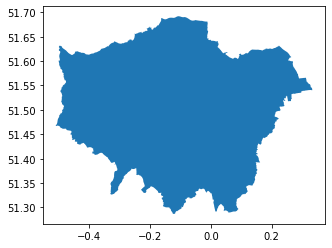

In [11]:
london_boundary.plot()

## 2.5 Spatial subsetting and CRS
In addition to subsetting by value, as we did with the UTLA boundaries earlier, we can also subset observations by evaluating their spatial relationship with another data set. We can for example select all UTLAs which are fully within Wales, every Output Area intersected by a river, or all households outside of city boundaries. There are a number of different spatial relationships which can be tested and used to subset observations.

### Spatial subsetting

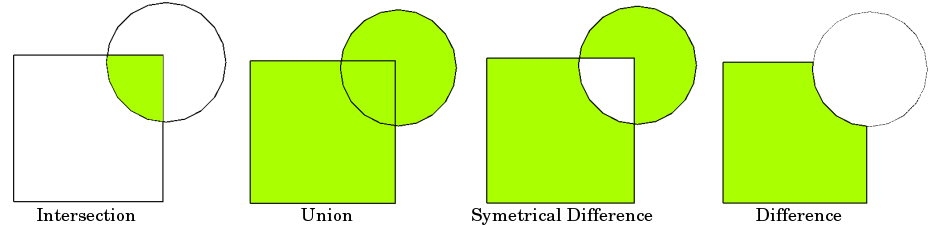

Geopandas has an inbuilt function called Overlay which we can use to spatially subset observations. The function takes several arguments:<br>
>*e.g.* **`spatial_subset = gpd.overlay(gpd1, gpd2, how ='operation')`**

- gdf1 - The GeoDataFrame we want to subset - **`lfb_gdf`**
- gdf2 - The GeoDataFrame used to evaluate the spatial relationship - **`london_boundary`**
- how - This is the argument where the **operation** is defined. <br>

Descriptions for each **operation** below:<br>
- With the **`intersects`** operation, the returned output will be only those geometries that are contained by both GeoDataFrames.
- The **`symmetrical_difference`** operation is the opposite of **`intersects`** in that it returns the geometries that are only part of one of the GeoDataFrame but not part of both.
- The **`difference`** operation returns geometries that are part of one GeoDataFrame but are not contained in the second GeoDataFrame.
- With the **`union`** operation, all possible geometries are returned.


### CRS


The Coordinate Reference System (CRS) are used to define the translation between a location on the round earth and that same location, on a flattened, 2 dimensional coordinate system. <br>
It is important to understand the coordinate system used in your data especially when working with data stored in a different CRS and collected from different sources. <br>
If you are working with multiple datasets of the same location that are stored in different CRS, they will not align. Before running any spatial operations on two spatial objects it is always worth checking if their CRSs match. Geopandas will throw an error if that’s not the case. 
> *For this exercise, we want to make sure that CRS is set to **`'espg:27700'`** which is the British National Grid (BNG).*<br>

You can run **`gdf.crs`** where **gdf** is your GeoDataFrame to check which CRS your data uses:
- Nothing will return if your GeoDataFrame does not have CRS specified. 
- In that case you will have to set CRS by running **`gdf.crs = 'epsg:27700'`** <br>


Where your datasets already have a CRS, quite often this may not match across all datasets. You may have to reproject from one CRS to another in this situation. To do this, you need to run **`gdf = gdf.to_crs(epsg:27700)`**.

*Try it for yourself below.*

### 2.5.1 Exercise - spatial subset part 1
- Use gpd.overlay to spatially subset **`lfb_gpd`** by testing its relationship with **`london_boundary`**.
- Use the 'intesection' operation

*Solution:*

In [12]:
lfb_london = gpd.overlay(lfb_gdf, london_boundary, how='intersection')

<ipython-input-12-d4f141cac5ac>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: EPSG:4326

  lfb_london = gpd.overlay(lfb_gdf, london_boundary, how='intersection')


### 2.5.2 Exercise - check CRS
- Run gdf.crs on each GeoDataFrame and compare the results.
- Another option is to run a boolean check on both GeoDataFrames and see what we get.

*Solution:*


Checking the CRS for **`lfb_gdf`**

**Boolean check**

In [13]:
london_boundary.crs == lfb_gdf.crs

False

It appears that they are different after all. This means that we have to reproject **`london_boundary`** to the correct CRS to make sure it matches with **`lfb_gdf`**.

### 2.5.3 Exercise - Reproject GeoDataFrame
- Match the CRSs on both GeoDataFrames by reprojecting **`london_boundary`** to BNG
- Run a boolean check again to make sure they now match

Reprojecting **`london_boundary`** to **`epsg:27700`**

In [14]:
london_boundary = london_boundary.to_crs(epsg=27700)

*Check if they now match*

In [15]:
london_boundary.crs == lfb_gdf.crs

True

Both GeoDataFrame are now in the same projection meaning that they both align which enables us to perform any spatial operations.

### 2.5.4 Exercise - spatial subset part 2
- Use gpd.overlay to spatially subset **`lfb_gdf`** by testing its relationship with **`london_boundary`**. Overwrite **`lfb_gdf`** with the subset data. This means that all points falling outside the London boundary are removed from the **`lfb_london dataset`**
- Plot it to check if the results are correct.

*Solution:*

In [16]:
lfb_gdf = gpd.overlay(lfb_gdf, london_boundary, how='intersection')

We have just overwritten our **`lfb_gdf`** to keep only point that fall within the **`london_boundary`** layer.

In [17]:
lfb_gdf.head()

,incident_number,cal_year,type_of_incident,cost_gbp,final_description,animal_group_parent,property_category,ward_code,ward,stn_ground_name,easting,northing,ctyua19cd,ctyua19nm,geometry
0,D1,2009,Special Service,510.0,"DOG WITH JAW TRAPPED IN MAGAZINE RACK,B15",Dog,Dwelling,E05011467,Crystal Palace & Upper Norwood,Norbury,532350,170050,E09000001,City of London,POINT (532350.000 170050.000)
1,F2,2009,Special Service,255.0,"ASSIST RSPCA WITH FOX TRAPPED,B15",Fox,Outdoor Structure,E05000169,Woodside,Woodside,534750,167550,E09000001,City of London,POINT (534750.000 167550.000)
2,D3,2009,Special Service,255.0,"DOG CAUGHT IN DRAIN,B15",Dog,Outdoor Structure,E05000558,Carshalton Central,Wallington,528050,164950,E09000001,City of London,POINT (528050.000 164950.000)
3,H4,2009,Special Service,255.0,"HORSE TRAPPED IN LAKE,J17",Horse,Non Residential,E05000330,Harefield,Ruislip,504650,190650,E09000001,City of London,POINT (504650.000 190650.000)
4,R5,2009,Special Service,255.0,"RABBIT TRAPPED UNDER SOFA,B15",Rabbit,Dwelling,E05000310,Gooshays,Harold Hill,554650,192350,E09000001,City of London,POINT (554650.000 192350.000)


Next, we may want to visualise our GeoDataFrame to see what it looks like.

<AxesSubplot:>

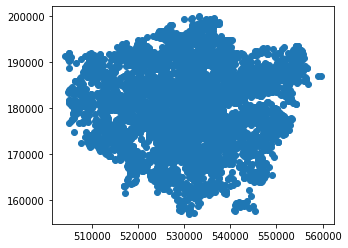

In [18]:
lfb_gdf.plot()

## 2.6 Spatial and non-spatial joins

Simple features data can be joined to other data sets in two ways. We can either use a traditional, SQL like join, based on a value shared across the data sets or, since we have a geometry column, on the spatial relationship between the data sets. This is known as a spatial join, where variables from one data set are joined to another one only on the basis of their spatial relationship. The most commonly used operation is known as a Point-in-Polygon join where data from a polygon is joined to the points within them.

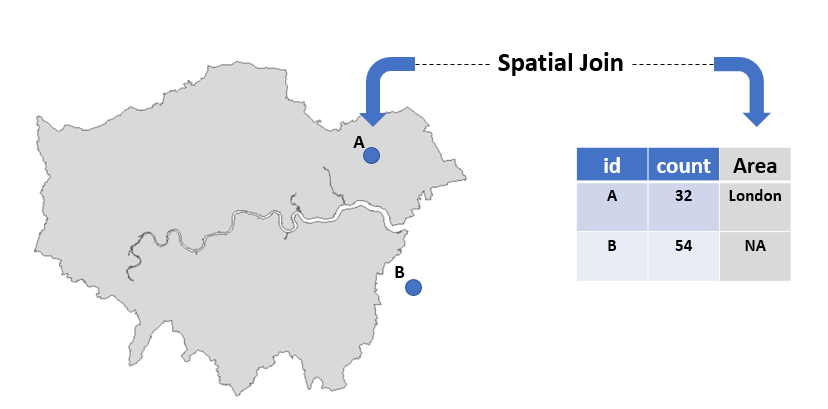

In Geopandas spatial joins are handled using the **`gpd.sjoin()`** function with arguments:<br>
>*e.g.* **`join_output = gpd.sjoin(gdf1, gdf2, how = 'inner', op = 'intersects')`**

- gdf1 - The GeoDataFrame to which we are joining data (LHS in SQL)
- gdf2 - The GeoDataFrame whose variables are being joined (RHS in SQL)
- how - The type of join we want to make
- op - The spatial operation we are using to perform the spatial join

We will be joining the Middle Super Output Areas to LFB locations, which will then allow us to group and plot data at MSOA level.

### 2.6.1 Exercise - spatial joins
- Read in data/shp/MSOA_2011_london/msoa_2011_ew_bgc.shp as **`msoa_london`** - use **`gpd.read_file()`**
- Check if **`msoa_london`**’s CRS and that of **`lfb_gdf`** match. Change **`msoa_london`** CRS if necessary.
- Create a new object called **`london_msoa_lfb`** by running **`gpd.sjoin()`** between **`lfb_gdf`** and **`msoa_london`**
- Inspect your new object using **.`head()`** to see what columns have been added.

Loading in our **`msoa_london`** layer.

In [19]:
msoa_london = gpd.read_file('data/shp/MSOA_2011_london/MSOA_2011_BSC_London.shp')

We may like to visualise our new layer to see what it looks like.

<AxesSubplot:>

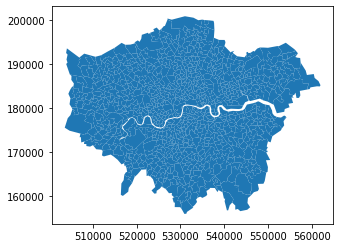

In [20]:
msoa_london.plot()

Checking what the table for our new layer looks like.

In [21]:
msoa_london.head()

,MSOA11CD,geometry
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18..."
1,E02000002,"POLYGON ((549000.726 190873.464, 549120.966 18..."
2,E02000003,"POLYGON ((548954.517 189063.241, 549085.611 18..."
3,E02000004,"POLYGON ((551943.782 186027.614, 551670.827 18..."
4,E02000005,"POLYGON ((549418.680 187442.412, 548983.438 18..."


Next, we need to make sure that our new layer aligns with our **`lfb_gdf`** layer. We'll start by checking that the CRSs match.

In [22]:
msoa_london.crs == lfb_gdf.crs

True

Now we can spatially join our two layers.

In [23]:
london_msoa_lfb = gpd.sjoin(msoa_london, lfb_gdf, how = 'inner', predicate = 'intersects')

We have just created a new layer called **`london_msoa_lfb`** using the **`.sjoin()`** function which merges our two GeoDataFrames based on their spatial relationship. This means that all emergency incidents in the **`lfb_gdf`** have been allocated to their respective msoa based on their locations. We can view our new layer below.

In [24]:
london_msoa_lfb.head()

,MSOA11CD,geometry,index_right,incident_number,cal_year,type_of_incident,cost_gbp,final_description,animal_group_parent,property_category,ward_code,ward,stn_ground_name,easting,northing,ctyua19cd,ctyua19nm
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18...",5107,C5370,2018,Special Service,333.0,SMALL ANIMAL RESCUE CAT FALLEN FROM SECOND FLO...,Cat,Dwelling,E05000367,BUNHILL,Dowgate,531850,181850,E09000001,City of London
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18...",4195,B4429,2016,Special Service,326.0,ASSIST RSPCA WITH TRAPPED BIRDS,Bird,Non Residential,E05009303,DOWGATE,Dowgate,532650,180850,E09000001,City of London
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18...",6053,B6358,2019,Special Service,339.0,BIRD TRAPPED UNDER LEDGE ON 7TH FLOOR,Bird,Non Residential,E05009291,BILLINGSGATE,Dowgate,533150,180850,E09000001,City of London
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18...",1697,B1784,2011,Special Service,520.0,BIRD TRAPPED IN WIRE,Bird,Outdoor,E05009303,Dowgate,Dowgate,532550,180850,E09000001,City of London
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18...",5323,B5589,2018,Special Service,333.0,SEAGULL TRAPPED BEHIND DOOR,Bird,Non Residential,E05009296,CANDLEWICK,Dowgate,532850,180850,E09000001,City of London


We may want to plot our new layer to see if anything has changed.

<AxesSubplot:>

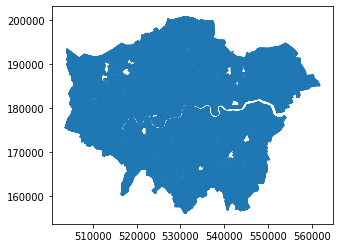

In [25]:
london_msoa_lfb.plot()

It appears we have a few areas missing in our new layer. This may indicate that there were no incidents recorded in those missing MSOAs.

### 2.6.2 Exercise - Checking points that didn't join

- Use **`gpd.overlay`**() and **`symmetric_difference`** to find point that didn't join.
- Save those to a new object called **`lfb_msoa_symmetric_difference`**
- Create an interactive map of the points and see why they did not join.
- Because we used the **`intersection`** operation on our **`gpd.sjoin`** function, none intersecting points were not included in the **`london_msoa_lfb`** output. <br>
There wont be any need to remove those.

*Solution*

In [26]:
lfb_msoa_symmetric_difference = gpd.overlay(lfb_gdf, london_msoa_lfb, how='symmetric_difference',keep_geom_type=True)

Now that we've created this new GeoDataFrame, we may want to check the table to find out some more information about these points that didn't join.

In [27]:
lfb_msoa_symmetric_difference

,incident_number_1,cal_year_1,type_of_incident_1,cost_gbp_1,final_description_1,animal_group_parent_1,property_category_1,ward_code_1,ward_1,stn_ground_name_1,...,animal_group_parent_2,property_category_2,ward_code_2,ward_2,stn_ground_name_2,easting_2,northing_2,ctyua19cd_2,ctyua19nm_2,geometry
0,D33,2009.0,Special Service,255.0,"DOG TRAPPED IN DRAIN UNDER BANDSTAND,B15",Dog,Non Residential,E05000348,Chiswick Homefields,Chiswick,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (521450.000 176750.000)
1,D54,2009.0,Special Service,255.0,"DOG STUCK IN MUD ON SHORELINE ,J15",Dog,Outdoor,E05000075,Erith,Erith,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (551650.000 178350.000)
2,C71,2009.0,Special Service,1275.0,"KITTEN STUCK IN MUD,J15",Cat,Outdoor,E05000075,Erith,Erith,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (551250.000 178550.000)
3,D218,2009.0,Special Service,260.0,"DOG CAUGHT IN BRAMBLES,B15",Dog,Outdoor,E05000593,Chingford Green,Chingford,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (540250.000 194850.000)
4,D1087,2010.0,Special Service,260.0,DOG IN RIVER ALONG TOW PATH,Dog,Outdoor,E05000524,Kew,Richmond,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (518850.000 177750.000)
5,B1122,2010.0,Special Service,260.0,BIRD TRAPPED BETWEEN ROOF TILES,Bird,Outdoor Structure,E05000349,Chiswick Riverside,Chiswick,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (520150.000 176650.000)
6,D1269,2011.0,Special Service,NaN,DOG IN DISTRESS IN RIVER,Dog,Outdoor,E05000416,Bishop's,Lambeth,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (530450.000 179050.000)
7,D1925,2012.0,Special Service,260.0,DOG TRAPPED ON MUD BANK OF RIVER THAMES,Dog,Outdoor,E05000362,Isleworth,Heston,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (516650.000 175850.000)
8,D2074,2012.0,Special Service,260.0,DOG IN DITCH,Dog,Outdoor,E05000524,Kew,Richmond,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (518150.000 177150.000)
9,D2178,2012.0,Special Service,260.0,DOG IN RIVER LEVEL 2 LINE OPS,Dog,Outdoor,E05000039,Thames,Barking,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (544850.000 182950.000)


We can see that there are only 35 points in total. Next, we may want to plot them on a map to understand why they may not have joined to the London layer. We'll use our dissolved London boundary to overlay our points layer.

<AxesSubplot:>

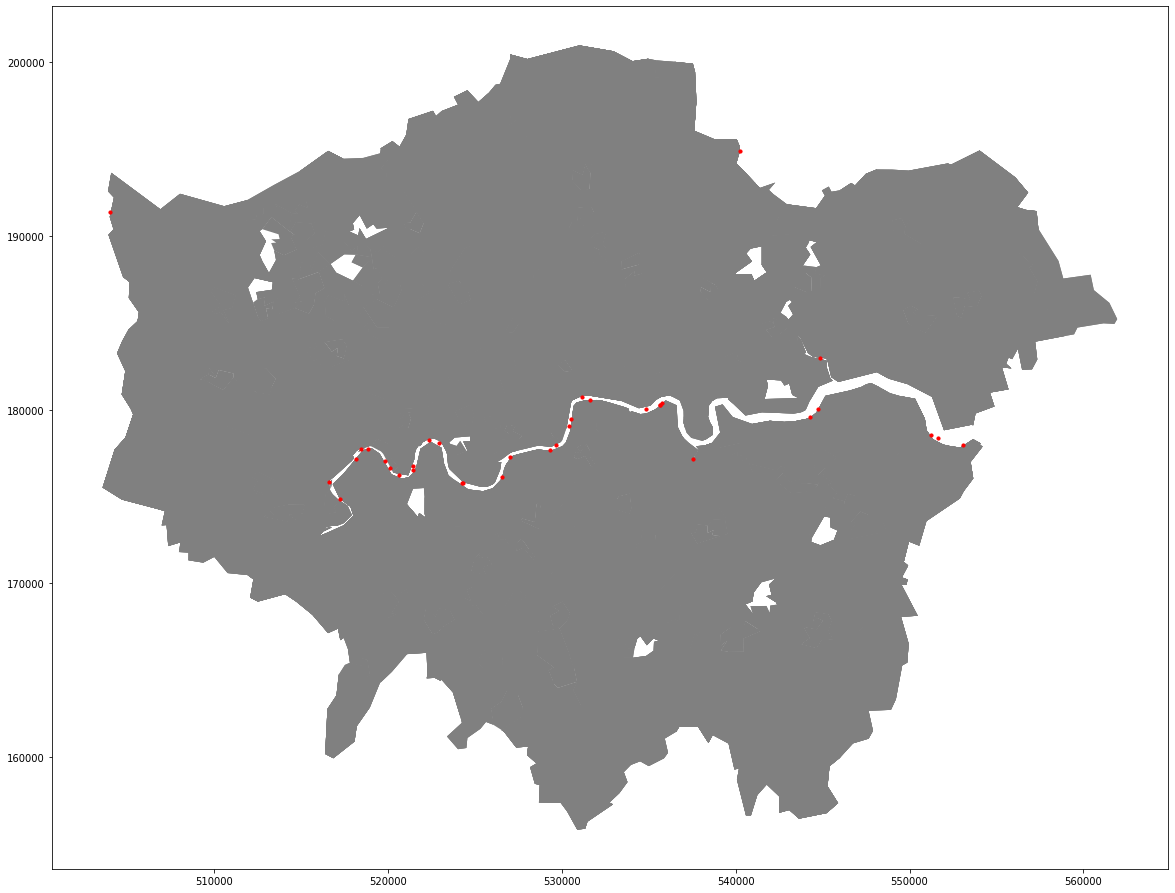

In [28]:
f, ax = plt.subplots(figsize=(20,20))
london_msoa_lfb.plot(ax=ax, color='grey')
lfb_msoa_symmetric_difference.plot(ax=ax, marker='o', color='red', markersize=10)

As we can see, the points that didn't join seem to be located on the edges of the London boundary. The ones in the centre are located on the edges of the Thames.

### 2.6.3 Exercise - MSOA summary statistics

- The step requires you to be familiar with pandas' more advanced functions. If you are struggling with this step load data/gpkg/msoa_lfb.gpkg as **`msoa_lfb`** using **`gpd.read_file()`**.
- Create summary statistics per MSOA - sum of **`cost_gbp`** as **`total_cost`** and the total number of incidents as **`n_cases`**. You will need to use **`.group_by()`** and **`.agg()`**
- Create a new column on **`lfb_msoa_stats`** called **`cost_per_incident`** using **`total_cost`** divided by **`n_cases`**. For example: <br> 
> **`df['new_column'] = df.column1/df.column2`**
- Join **`lfb_msoa_stats`** to **`msoa_london`**, using the **`.merge()`** function with **`left_join()`** and create a new object **`msoa_lfb`**

In [29]:
lfb_msoa_stats = london_msoa_lfb.groupby('MSOA11CD').cost_gbp.agg(['count', 'sum']).reset_index().rename(columns={'count':'n_cases','sum' : 'total_cost'})

We have just grouped our DataFrame by **`msoa11cd`** and aggregated the **`cost_gbp`** column by count and sum. The first column will become a default index for the dataframe and so we need to use the **`reset_index()`** function to keep the integer values as the index.

In [30]:
lfb_msoa_stats.head()

,MSOA11CD,n_cases,total_cost
0,E02000001,13,4083.0
1,E02000002,6,1926.0
2,E02000003,11,4779.0
3,E02000004,7,2917.0
4,E02000005,5,1411.0


Next, we want to create a new column called **`cost_per_incident`** by diving **`total_cost`** by **`n_cases`**

In [31]:
lfb_msoa_stats['cost_per_incident'] = lfb_msoa_stats.total_cost/lfb_msoa_stats.n_cases

We finally have our summary stats. We can now view our DataFrame.

In [32]:
lfb_msoa_stats.head()

,MSOA11CD,n_cases,total_cost,cost_per_incident
0,E02000001,13,4083.0,314.076923
1,E02000002,6,1926.0,321.000000
2,E02000003,11,4779.0,434.454545
3,E02000004,7,2917.0,416.714286
4,E02000005,5,1411.0,282.200000


For our next exercise, we want to map our summary stats for our London MSOAs. We need to turn our DataFrame into a GeoDataFrame again by merging our **`msoa_london`** layer which has a geometry column to our **`lfb_msoa_stats`** DataFrame which has the summary stats.

In [33]:
msoa_lfb = pd.merge(msoa_london, lfb_msoa_stats, on = 'MSOA11CD', how = 'left')

Now we can take a look at our final GeoDataFrame.

In [34]:
msoa_lfb.head()

,MSOA11CD,geometry,n_cases,total_cost,cost_per_incident
0,E02000001,"POLYGON ((532946.065 181894.827, 533410.692 18...",13.0,4083.0,314.076923
1,E02000002,"POLYGON ((549000.726 190873.464, 549120.966 18...",6.0,1926.0,321.000000
2,E02000003,"POLYGON ((548954.517 189063.241, 549085.611 18...",11.0,4779.0,434.454545
3,E02000004,"POLYGON ((551943.782 186027.614, 551670.827 18...",7.0,2917.0,416.714286
4,E02000005,"POLYGON ((549418.680 187442.412, 548983.438 18...",5.0,1411.0,282.200000


>If something has gone wrong with your final output, a complete **`MSOA_2011_BFE_London.gpkg`** is available in the data folder for you to load and use.

### 2.6.4 Exercise - save data to shapefile

Saving your GeoDataFrame as a shapefile can be done this using the **`output_filename.to_file()`** function. It needs the following to create a spatial output: <br>
- A GeoDataFrame
- The file path where the output is to be stored
- A name for the output
- The file extension for the spatial output. e.g.(**`.shp`** for shapefiles) 

In [35]:
#msoa_lfb.to_file('D:/2021/Spatial/Introduction_to_GIS_in_Python/outputs/msoa_lfb.shp')

## 3 Making better maps

Now that we have processed our data we can start mapping it. <br>

The maps we have created so far are only for a basic view of what our GeoDataFrame layer looks like and not necessary to reveal any important underlying data within them. We want to create a map which is more useful by specifying a column we want to visualise on GeoDataFrame.
The following is a step by step guide to creating a choropleth map using **`msoa_lfb`**.

We will start by plotting our final GeoDataFrame as we have done throughout the exercises.

<AxesSubplot:>

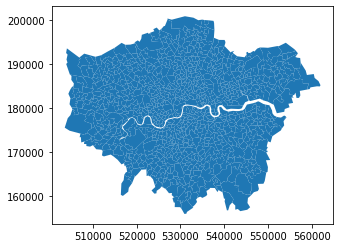

In [36]:
msoa_lfb.plot()

### 3.1 Doing more within our map. 

Next, we may want to Increase the size of our map to make it larger on the screen. We will need an additional command to achieve this. <br>
The **`plt.subplots()`** command, when called without any inputs, creates two different objects: a Figure object (**`fig`**) and an Axes object (**`ax`**). <br>
The Figure object is a container that holds everything that you see on the page. The Axes is the part of the page that holds the data. It is the canvas on which we will draw with our data, to visualize it

It is also this canvas that we need to manipulate in order to increase the size of our map. This is specified with the argument **`figsize`**. 
The first number represents the width, the X axis, and the second corresponds with the height, the Y axis.

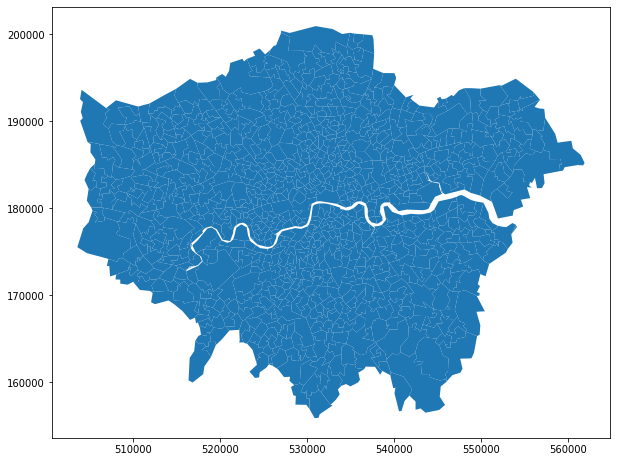

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = msoa_lfb.plot(ax=ax)

We can specify a variable that we would like the map to visualise. We just need to set the column argument equal to a column with normalised numerical data. We can do this by passing **`cost_per_incident`** onto the column argument.<br>The holes on the map indicate that there is missing data. We will have to take this into consideration for our finished map.

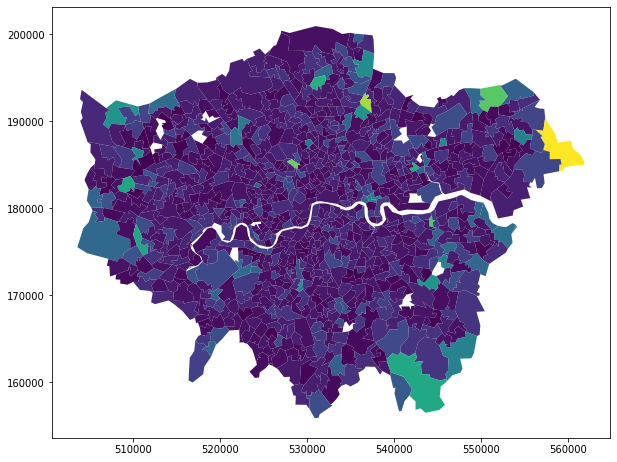

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = msoa_lfb.plot(column='cost_per_incident', ax=ax)

We can also select a classification method to bin our data into categories. We will use Quantiles and pass it onto the **`scheme`** argument. The **`k`** argument specifies the number of categories we want to split our data by. 

<AxesSubplot:>

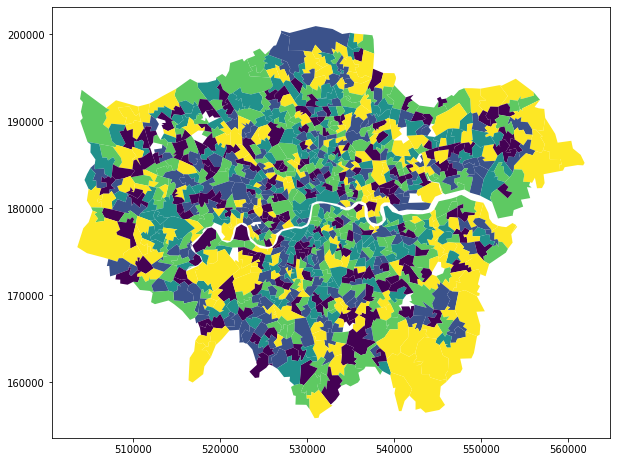

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_lfb.plot(column='cost_per_incident', scheme='Quantiles',k = 5, ax=ax)

We can also specify a colour using the cmap argument. 
cmap which stands for colormap is an inbuilt matplotlib dictionary that contains various sets of colour styles. 
The matplotlib colormaps are divided into the following categories: **Sequantial**, **Diverging**, and **Qualitative**. A list of some of the colour options are given below:

- **Perceptually Uniform Sequential** <br>`['viridis', 'plasma', 'inferno', 'magma']`

- **Sequential** <br>`['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']`

- **Diverging**<br>`['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']`

- **Qualitative**<br>`['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']`

- **Miscellaneous**<br>`['flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv', 'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']`

Geopandas selects a sequantial colourmap when the column plotted has numerical data. The default colourmap is called **`viridis`**. We need to change this to a more appropriate colourmap for a choropleth map. For example, something that has colours that stay near or in the same colour family.
We are interested in a sequantial colour style and will be selecting `'Blues'`. 
To add a legend, we just need to pass **`legend = True`** and this will do the job.

<AxesSubplot:>

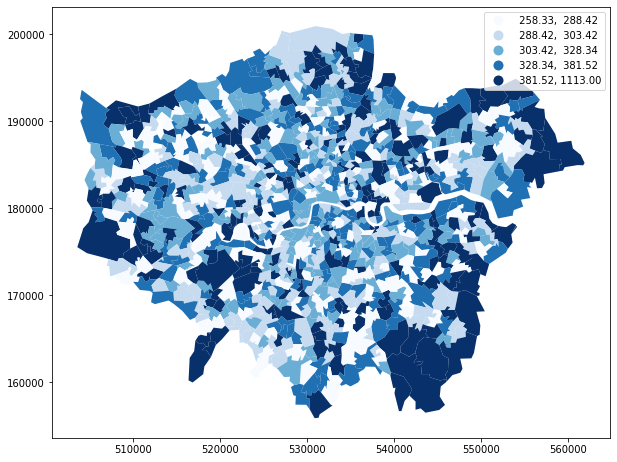

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_lfb.plot(column='cost_per_incident', scheme='Quantiles',k = 5, cmap = 'Blues', legend =True, ax=ax)

We can add a title to out map using the **`plt.title()`** function

Text(0.5, 1.0, 'Cost of animal related incidents per MSOA, between 2009 and 2020')

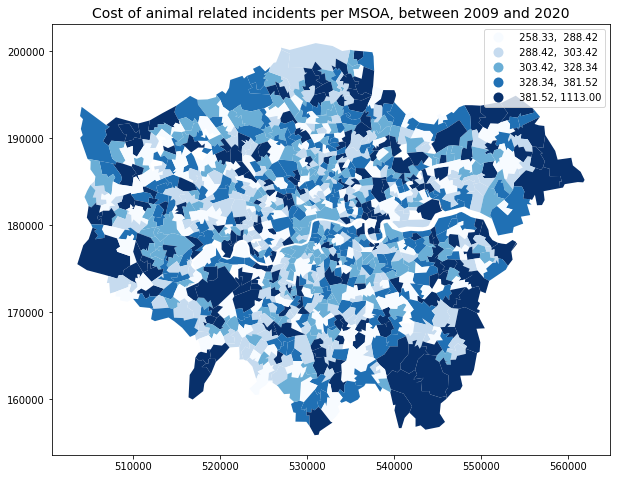

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_lfb.plot(column= 'cost_per_incident', ax = ax, scheme='QUANTILES', k = 5, cmap='Blues', legend=True)
plt.title('Cost of animal related incidents per MSOA, between 2009 and 2020', size = 14)

We can also change our mapped variable and select a different classification scheme to split our data. We will use **`equal_interval`** and increase our number of categories to five on the **`total_cost`** variable.

Text(0.5, 1.0, 'Cost of animal related incidents per MSOA, between 2009 and 2020')

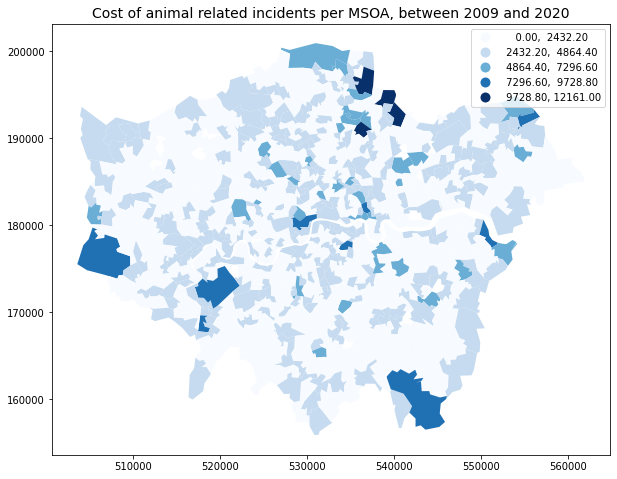

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_lfb.plot(column= 'total_cost', ax = ax, scheme='equal_interval', k = 5, cmap='Blues', legend=True)
plt.title('Cost of animal related incidents per MSOA, between 2009 and 2020', size = 14)

We can also increase the number of our categories using the **`k=`** argument. We will increase ours to *`9`* for the map.

Text(0.5, 1.0, 'Cost of animal related incidents per MSOA, between 2009 and 2020')

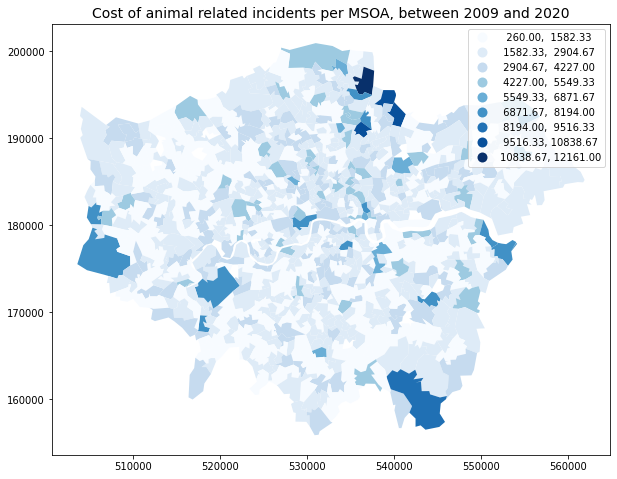

In [43]:
ax = msoa_lfb.dropna().plot(column='total_cost', cmap='Blues', figsize=(10,10), scheme='equal_interval', k=9, legend=True)
plt.title('Cost of animal related incidents per MSOA, between 2009 and 2020', size = 14)

Alternatively, we may want to use a customised classification to break our data. We need the **`classification_kwds=dict(bins=[])`** argument to achieve this and specify the bins inside the square brackets. <br>
As we know from one of the previous maps, some areas on the map have no data and will normally have a white background. This is often hard to spot on a sequential colour style therefore we need to distinguish these areas from those which have low category values shown with the lighter colour shades. <br>

We will have to add a new category to highlight such areas on the map and label them on the legend as missing values.<br> 
The argument **`missing_kwds`** enables this functionality. **`"color"`** controls how areas with missing values will be represented on the map while **`"label"`** defines the description to be shown on the legend.

Text(0.5, 1.0, 'Cost of animal related incidents per MSOA, between 2009 and 2020')

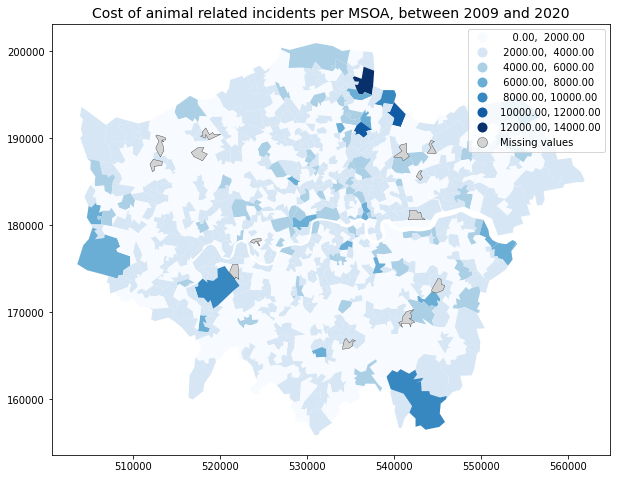

In [44]:
ax = msoa_lfb.plot(column='total_cost', cmap='Blues', figsize=(10,10), scheme="User_Defined", legend=True, 
                   classification_kwds={'bins':[2000, 4000, 6000, 8000, 10000, 12000, 14000]}, 
                   missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},)
plt.title('Cost of animal related incidents per MSOA, between 2009 and 2020', size = 14)

Now that we have our legend and happy with the categories to classify our data, we need to tidy up our canvas by increasing the figure size and moving our legend. We will also add a title for our legend.<br>
This can be done using the **`legend_kwds`** argument. We can also specify the position of our legend on the map within this argument. 

Text(0.5, 1.0, 'Cost of animal related incidents per MSOA, between 2009 and 2020')

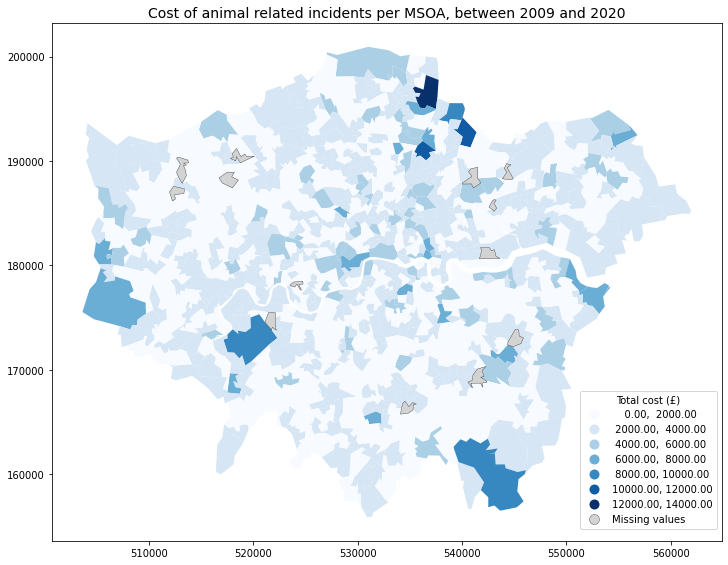

In [45]:
ax = msoa_lfb.plot(column='total_cost', cmap='Blues', figsize=(12,10), scheme="User_Defined", legend=True, 
                   classification_kwds={'bins':[2000, 4000, 6000, 8000, 10000, 12000, 14000]},
                   missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
                   legend_kwds={'bbox_to_anchor':(1,0.3), 'title':'Total cost (£)'})
plt.title('Cost of animal related incidents per MSOA, between 2009 and 2020', size = 14)

Looking at our map, it is clear that regions with similar values can be hard to differentiate. It can also be difficult to identify the edges of our map where the colours are light making it seem like they merge with the white background.
We can get around this to add a bit of clarity on our map with some boundary lines for each area by using **`edgecolor`** to outline the area polygons and **`linewidth`** to set the thickness of the lines. <br>
**`0`** is the lowest value you can assign for **`linewidth`** and **`1`** the highest.

Text(0.5, 1.0, 'Cost of animal related incidents per MSOA, between 2009 and 2020')

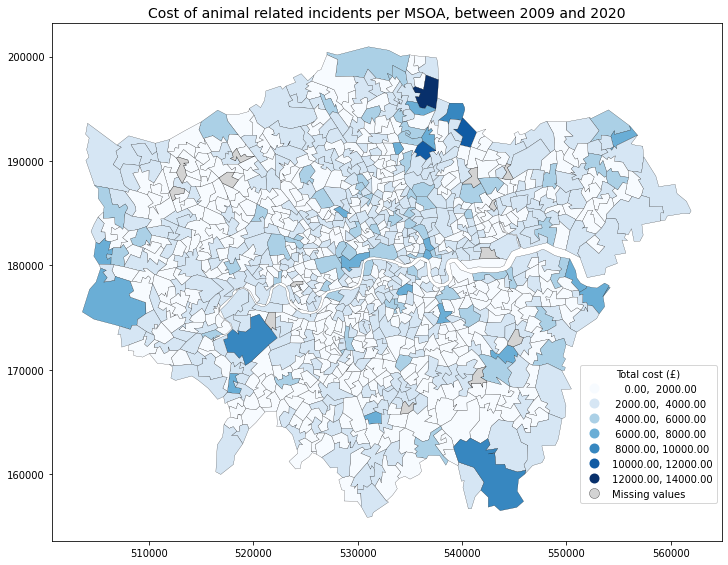

In [46]:
ax = msoa_lfb.plot(column='total_cost', cmap='Blues', edgecolor = 'k', 
                   linewidth = 0.2, figsize=(12,10), scheme="User_Defined", legend=True,
                   classification_kwds={'bins':[2000, 4000, 6000, 8000, 10000, 12000, 14000]},
                   missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
                   legend_kwds={'bbox_to_anchor':(1,0.35), 'title':'Total cost (£)'})
plt.title('Cost of animal related incidents per MSOA, between 2009 and 2020', size = 14)

Mapping **Average cost per incident** and redefining our customised categories.

Text(0.5, 1.0, 'Average cost of animal related incidents between 2009 and 2020')

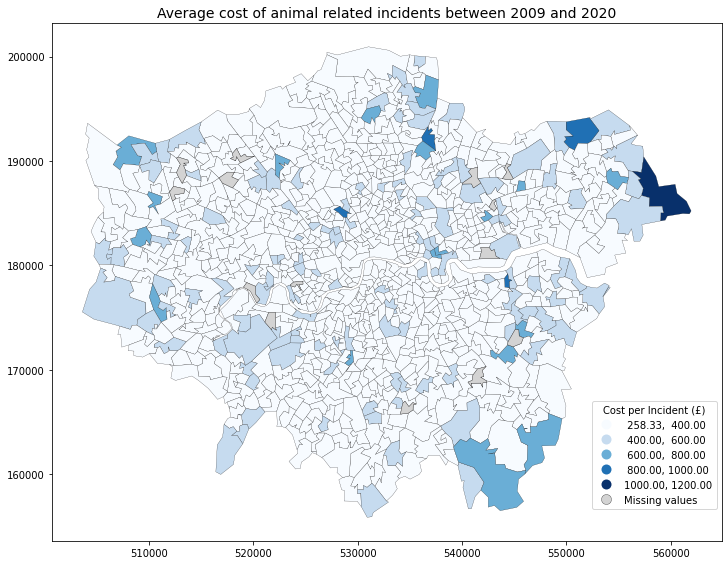

In [47]:
ax = msoa_lfb.plot(column='cost_per_incident', cmap='Blues', edgecolor = 'k', 
                   linewidth = 0.2, figsize=(12,10), scheme="User_Defined", legend=True,
                   classification_kwds={'bins':[400, 600, 800, 1000, 1200]},
                   missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
                   legend_kwds={'bbox_to_anchor':(1,0.28), 'title':'Cost per Incident (£)'})
plt.title('Average cost of animal related incidents between 2009 and 2020', size = 14)

Adding the Greater London boundary to the map:
Something to improve the aesthetics on our map. The border is an important feature for highlighting the edges of the mappped area. It will also give our map a sharper look as the edges stand out more.

Text(0.5, 1.0, 'Average cost of animal related incidents between 2009 and 2020')

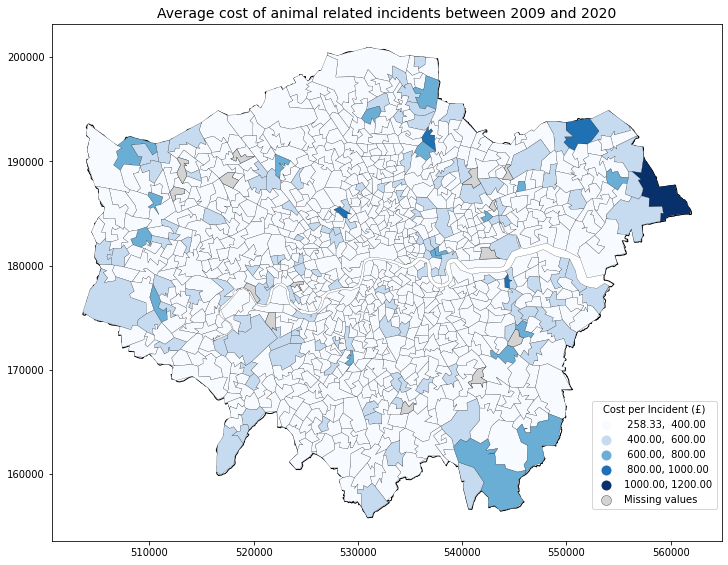

In [48]:
f, ax = plt.subplots(figsize=(12,10))
london_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth = 1)
msoa_lfb.plot(ax=ax, column='cost_per_incident', cmap='Blues', edgecolor = 'k', 
              linewidth = 0.2, figsize=(12,10), scheme="User_Defined", legend=True,
              classification_kwds={'bins':[400, 600, 800, 1000, 1200]},
              missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
              legend_kwds={'bbox_to_anchor':(1,0.28), 'title':'Cost per Incident (£)'})
plt.title('Average cost of animal related incidents between 2009 and 2020', size = 14)

Adding copyright statements to the map

Text(0.14, 0.148, 'Source: ONS, licensed under the open Government license v3.0')

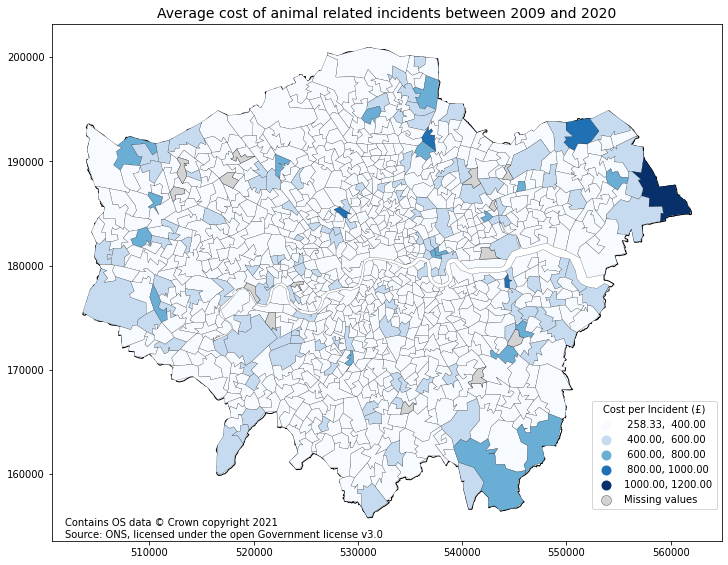

In [49]:
f, ax = plt.subplots(figsize=(12,10))
london_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth = 1)
msoa_lfb.plot(ax=ax, column='cost_per_incident', cmap='Blues', edgecolor = 'k', 
              linewidth = 0.2, figsize=(12,10), scheme="User_Defined", legend=True,
              classification_kwds={'bins':[400, 600, 800, 1000, 1200]},
              missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
              legend_kwds={'bbox_to_anchor':(1,0.28), 'title':'Cost per Incident (£)'})
plt.title('Average cost of animal related incidents between 2009 and 2020', size = 14)
f.text(0.14,0.165,'Contains OS data © Crown copyright 2021')
f.text(0.14,0.148, 'Source: ONS, licensed under the open Government license v3.0')

### 3.2 Saving maps to figures

Exporting maps a map in Python can be done by using the command **`plt.savefig`**.

We just need to specify the filetype as **`.png`**. We can also add an additional argument to this to specify the size we wish our image to be. For example, for a high definition quality image, we can use 1080. <br>
>**`plt.savefig('output_name.png', dpi = 300)`**

Text(0.14, 0.148, 'Source: ONS, licensed under the open Government license v3.0')

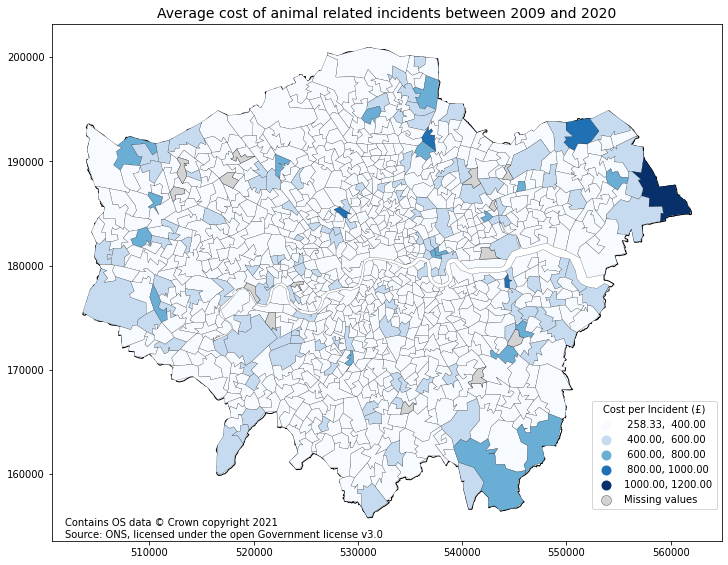

In [50]:
f, ax = plt.subplots(figsize=(12,10))
london_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth = 1)
msoa_lfb.plot(ax=ax, column='cost_per_incident', cmap='Blues', edgecolor = 'k', 
              linewidth = 0.2, figsize=(12,10), scheme="User_Defined", legend=True,
              classification_kwds={'bins':[400, 600, 800, 1000, 1200]},
              missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
              legend_kwds={'bbox_to_anchor':(1,0.28), 'title':'Cost per Incident (£)'})
plt.title('Average cost of animal related incidents between 2009 and 2020', size = 14)
f.text(0.14,0.165,'Contains OS data © Crown copyright 2021')
f.text(0.14,0.148, 'Source: ONS, licensed under the open Government license v3.0')
#plt.savefig('R:/Musa/Geospatial/2021/Spatial/Intro_GIS_Python/outputs/msoa_lfb.png', dpi = 300)

**Congratulations!** You have completed the Introduction to Geography in Python Course. **Well done!**